In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Concatenate, Reshape, Embedding, GlobalAveragePooling1D, Lambda

2025-05-01 18:19:27.745871: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
def read_csv_head(input_file, num_lines):
    """
    Đọc num_lines dòng đầu tiên từ file CSV (kể cả dòng header) và trả về dưới dạng list.
    
    :param input_file: Đường dẫn file CSV.
    :param num_lines: Số dòng muốn lấy (bao gồm header).
    :return: Danh sách các dòng đã lấy.
    """
    result = []
    with open(input_file, 'r', newline='', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)
        for i, row in enumerate(reader):
            if i >= num_lines:
                break
            result.append(row)
    return result

In [3]:
data_namp = read_csv_head(r'/mnt/nvme1/nAMP_GenBank.csv', 1150001)  # 1 dòng tiêu đề + 2500 dòng dữ liệu
data_namp = pd.DataFrame(data_namp[1:], columns=data_namp[0])
# data_namp

In [4]:
# data_amp = pd.read_csv(r'/mnt/nvme1/AMP_GenBank.csv')
data_amp = pd.read_csv(r'/mnt/nvme1/AMP_GenBank.csv')  # 1 dòng tiêu đề + 2500 dòng dữ liệu
# data_amp
# data_amp = read_csv_head(r'/mnt/nvme1/AMP_GenBank.csv', 600000)  # 1 dòng tiêu đề + 2500 dòng dữ liệu
# data_amp = pd.DataFrame(data_amp[1:], columns=data_amp[0])

In [5]:
combinated_data = pd.concat([data_namp, data_amp], ignore_index=True)
# data

In [6]:
data, data_test = train_test_split(combinated_data, test_size=0.3, stratify=combinated_data['Label'], random_state=42, shuffle=True)

In [7]:
# data1 = pd.read_csv("input/features.csv")
# data1

In [8]:
# data2 = pd.read_csv("input/features5.csv")
# data2

In [9]:
# data = pd.concat([data1, data2], ignore_index=True)
# data

In [10]:
# data_test = pd.read_csv("input/features_test.csv")
# data_test

### Cột "ID" có thể chỉ là một định danh duy nhất cho từng dòng, không mang ý nghĩa đặc biệt trong mô hình.

In [11]:
data = data.drop(columns=['ID'])
data_test = data_test.drop(columns=['ID'])

In [12]:
# data.info()

In [13]:
# data_test.info()

### Kiểm tra và xóa số lượng rows trùng lặp

In [14]:
# data.duplicated().sum()

In [15]:
# data_test.duplicated().sum()

In [16]:
# data = data.drop_duplicates()
# data_test = data_test.drop_duplicates()

In [17]:
# data.duplicated().sum()

In [18]:
# data_test.duplicated().sum()

### Kiểm tra xem có cột nào chứa giá trị NaN (khuyết thiếu) hay không.

In [19]:
# null_columns_1 = data.columns[data.isnull().sum() > 0]
# print(data[null_columns_1].isnull().sum())

# null_columns_2 = data_test.columns[data_test.isnull().sum() > 0]
# print(data[null_columns_2].isnull().sum())

### Phân loại các cột theo kiểu dữ liệu
#### - float_columns: Chứa các cột có kiểu dữ liệu float64 (biến số học).
#### - object_columns: Chứa các cột có kiểu dữ liệu object (biến dạng chuỗi).

In [20]:
float_columns = data.select_dtypes(include=['float64']).columns
object_columns = data.select_dtypes(include=['object']).columns

### Dữ liệu có 2 cột dạng chuỗi:
#### - Label: Có thể là nhãn phân loại (ví dụ: Antimicrobial vs Non-Antimicrobial hoặc 1 vs 0).
#### - Sequence: Chuỗi peptide cần dự đoán.

In [21]:
# object_columns

### Chuyển đổi nhãn (Label) từ chuỗi sang số (0/1):
#### - Nếu Label == 'nAMP' → gán 0 (Không kháng khuẩn).
#### - Nếu không phải 'nAMP' → gán 1 (Kháng khuẩn).
### Chuyển đổi kiểu dữ liệu thành float để phù hợp với mô hình.

In [22]:
data.loc[:, 'Label'] = data['Label'].apply(lambda x: 0 if x == 'nAMP' else 1)
data['Label'] = data['Label'].astype(float)

data_test.loc[:, 'Label'] = data_test['Label'].apply(lambda x: 0 if x == 'nAMP' else 1)
data_test['Label'] = data_test['Label'].astype(float)

# data

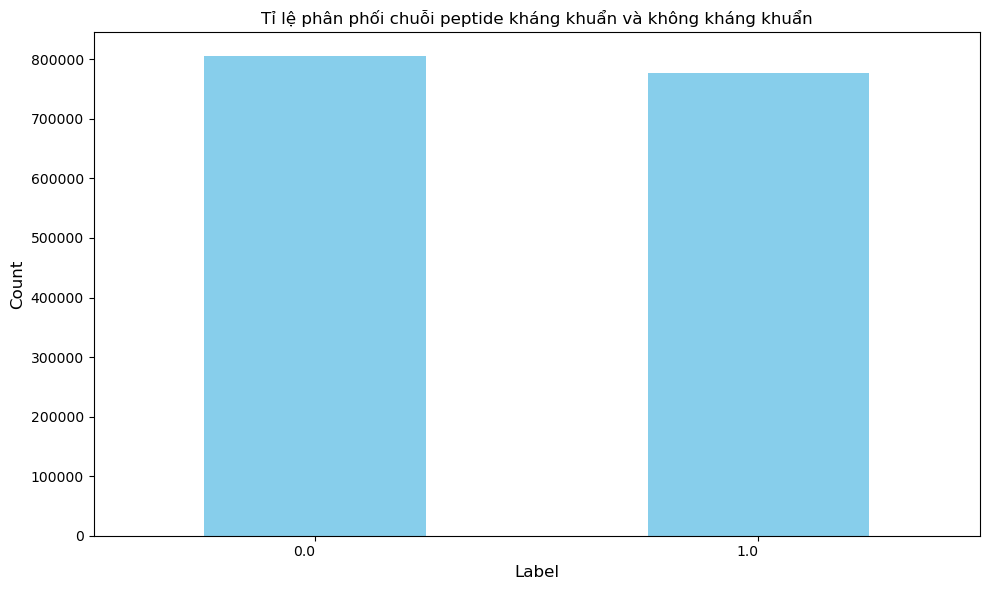

In [23]:
label_counts = data['Label'].value_counts()
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color = 'skyblue')
plt.title('Tỉ lệ phân phối chuỗi peptide kháng khuẩn và không kháng khuẩn')
plt.xlabel('Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()

In [24]:
x_test = data_test.drop(columns=['Label'])
y_test = data_test['Label']

X_train = data.drop(columns=['Label'])
y_train = data['Label']

### Kiểm tra (mẫu, đặc trưng)

In [25]:
# print(x_test.shape)
# print(y_test.shape)

# print(X_train.shape)
# print(y_train.shape)

In [26]:
X_val, X_test, Y_val, Y_test = train_test_split(x_test, y_test, test_size=0.5, stratify=y_test, random_state=42, shuffle=True)

### chuỗi sequence dạng chữ, chuyển về chuỗi số

In [27]:
# sequence_lengths = [len(seq) for seq in  data['Sequence']]  

# # Tính giá trị percentile 95%
# max_length = int(np.percentile(sequence_lengths, 95))  
# print(f"Max length hợp lý dựa trên 95% dữ liệu: {max_length}")

### Đệm hoặc cắt ở phía sau
###  Lý do chọn 'post':
#### - Giữ thông tin quan trọng ở đầu chuỗi, vì đầu peptide có thể chứa thông tin quan trọng về tính kháng khuẩn.

In [28]:
# pip install tensorflow

In [29]:
max_length = 50

padding_type = 'post' # Đệm thêm số 0
trunc_type = 'post'  # Cắt nếu chuỗi dài

In [30]:
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(data['Sequence'])
vocab_size = len(tokenizer.word_index) + 1
print("Vocab Size: ",vocab_size)

Vocab Size:  26


In [31]:
tokenizer.word_index

{'r': 1,
 'l': 2,
 'a': 3,
 'k': 4,
 'g': 5,
 'v': 6,
 's': 7,
 't': 8,
 'i': 9,
 'p': 10,
 'q': 11,
 'f': 12,
 'n': 13,
 'e': 14,
 'y': 15,
 'd': 16,
 'm': 17,
 'h': 18,
 'w': 19,
 'c': 20,
 'x': 21,
 'j': 22,
 'b': 23,
 'z': 24,
 'u': 25}

In [32]:
train_sequences  = tokenizer.texts_to_sequences(X_train['Sequence'])
train_sequence_array = pad_sequences(train_sequences , maxlen= max_length, padding= padding_type, truncating=trunc_type)

val_sequences = tokenizer.texts_to_sequences(X_val['Sequence'])
val_sequence_array = pad_sequences(val_sequences , maxlen= max_length, padding= padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(X_test['Sequence'])
test_sequence_array = pad_sequences(test_sequences , maxlen= max_length, padding= padding_type, truncating=trunc_type)

In [33]:
X_train= X_train.drop(columns=['Sequence'])
X_train['train_sequences'] = train_sequence_array.tolist()

X_val= X_val.drop(columns=['Sequence'])
X_val['val_sequences'] = val_sequence_array.tolist()

X_test= X_test.drop(columns=['Sequence'])
X_test['test_sequences'] = test_sequence_array.tolist()

In [34]:
# X_train.describe()

In [35]:
# columns_with_max_equal_1 = X_train.columns[X_train.max() == 1]
# columns_with_min_equal_0 = X_train.columns[X_train.min() == 0]

# # In kết quả
# print("Các cột có max == 1:", len(list(columns_with_max_equal_1)))
# print("Các cột có min == 0:", len(list(columns_with_min_equal_0)))

## Kiểm tra X_train
#### Tổng có 127 cột. Tách thành 126 + 1 cột mảng

In [36]:
# print(X_train.dtypes.value_counts())

In [37]:
X_train_num = X_train.iloc[:, :126]  # Chọn 126 cột đầu tiên
X_train_text = X_train.iloc[:, -1]   # Chọn cột cuối cùng

In [38]:
# object_cols = X_train.select_dtypes(include=['object']).columns
# print("Cột object:", object_cols)

In [39]:
# print(X_train_text.head(10))  # Xem 10 dòng đầu

## Kiểm tra X_val
#### Tổng có 127 cột. Tách thành 126 + 1 cột mảng

In [40]:
# print(X_val.dtypes.value_counts())

In [41]:
X_val_num = X_val.iloc[:, :126]  # Chọn 126 cột đầu tiên
X_val_text = X_val.iloc[:, -1]   # Chọn cột cuối cùng

In [42]:
# print(X_val_text.head(10))  # Xem 10 dòng đầu

## Kiểm tra dữ liệu huấn luyện
In thử một vài giá trị trong X_train và X_val để kiểm tra xem có giá trị âm hoặc không hợp lệ không

In [43]:
# print(f"X_train_text - NaN: {pd.isna(X_train_text).sum()} / Total: {X_train_text.size}")
# print(f"X_val_text - NaN: {pd.isna(X_val_text).sum()} / Total: {X_val_text.size}")

In [44]:
# X_train_num = np.array(X_train_num, dtype=np.float32)
# X_val_num = np.array(X_val_num, dtype=np.float32)
X_train_num = X_train_num.to_numpy(dtype=np.float32)
X_val_num = X_val_num.to_numpy(dtype=np.float32)

In [45]:
# Định nghĩa độ dài cố định cho X_train_text và X_val_text
max_len = max_length  

# Chuyển đổi tất cả thành danh sách cùng kích thước
X_train_text = np.array([seq[:max_len] + [0] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len] for seq in X_train_text], dtype=np.int32)

X_val_text = np.array([seq[:max_len] + [0] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len] for seq in X_val_text], dtype=np.int32)

print("X_train_text shape:", X_train_text.shape)
print("X_val_text shape:", X_val_text.shape)

X_train_text shape: (1581599, 50)
X_val_text shape: (338914, 50)


### Các class huấn luyện model
#### - Điều kiện quan trọng: embed_dim phải chia hết cho heads để mỗi đầu Attention có kích thước vector bằng nhau.
#### - Thông thường, số neurons trong FFN (neurons) nên gấp 2-4 lần embed_dim để mô hình có đủ khả năng trích xuất đặc trưng.
#### - Gợi ý công thức: neurons = 2 × embed_dim hoặc neurons = 4 × embed_dim.

In [46]:
# Định nghĩa Transformer Encoder
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, heads, neurons):
        super(TransformerEncoder, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=heads, key_dim=embed_dim // heads) # NOTE
        self.ffn = tf.keras.Sequential([
            layers.Dense(neurons, activation="relu"),
            layers.Dense(embed_dim)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(0.2)
        self.dropout2 = layers.Dropout(0.2)

    def call(self, inputs, training=None, mask=None):
        if mask is not None:
            # MHA yêu cầu mask shape: (batch_size, 1, 1, seq_len) hoặc (batch_size, seq_len)
            mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)  # (batch_size, 1, seq_len)
    
        attn_output = self.att(inputs, inputs, attention_mask=mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Lớp embedding cho chuỗi văn bản
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.maxlen = maxlen
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        positions = tf.range(start=0, limit=self.maxlen, delta=1)
        positions = self.pos_emb(positions)
        x_embed = self.token_emb(x)
        return x_embed + positions, self.token_emb.compute_mask(x)


class MultiLayerTransformerEncoder(layers.Layer):
    def __init__(self, num_layers, embed_dim, heads, neurons):
        super(MultiLayerTransformerEncoder, self).__init__()
        self.encoders = [
            TransformerEncoder(embed_dim, heads, neurons)
            for _ in range(num_layers)
        ]

    def call(self, x, mask=None, training=False):
        for encoder_layer in self.encoders:
            x = encoder_layer(x, training=training, mask=mask)

        return x

In [47]:
# ==== THAM SỐ ====
# Đảm bảo TensorFlow đang chạy trong Eager Execution

embed_dim = 200   # Kích thước vector embedding
heads = 6        # Số đầu attention
neurons = 400     # Số nơ-ron của lớp fully connected
maxlen = 50      # Chiều dài chuỗi đầu vào (thay max_length bằng 100)
num_features = 126  # Số lượng cột số đầu vào
vocab_size = vocab_size   # Kích thước từ vựng
num_layers = 4    # Số lớp transformer encoder

# ==== ĐỊNH NGHĨA INPUT ====
# Input cho dữ liệu số
num_input = Input(shape=(num_features,))
num_reshaped = Dense(embed_dim, activation="relu")(num_input)
num_reshaped = Reshape((1, embed_dim))(num_reshaped)  # Shape: (batch_size, 1, embed_dim)

# Input văn bản
text_input = Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
text_embedded, text_mask = embedding_layer(text_input)  # Shape: (batch_size, maxlen, embed_dim), (batch_size, maxlen)

# Ghép 2 đầu vào: (1 + maxlen, embed_dim)
merged_input = Concatenate(axis=1)([num_reshaped, text_embedded])

# Ghép mask: num_input không phải padding → mask = 1
def create_combined_mask(text_mask):
    # Tạo mask cho dữ liệu số (num_input) với giá trị là 1
    num_mask = tf.ones_like(text_mask[:, :1], dtype=tf.int32)  # num_mask sẽ có kiểu int32
    text_mask = tf.cast(text_mask, dtype=tf.int32)  # Chuyển text_mask sang kiểu int32
    return tf.concat([num_mask, text_mask], axis=1)


merged_mask = Lambda(
    create_combined_mask,
    output_shape=(maxlen + 1,)
)(text_mask)

# Nếu cần, reshape thêm cho phù hợp với attention mask yêu cầu
merged_mask = Lambda(lambda x: tf.cast(tf.expand_dims(x, axis=1), tf.float32))(merged_mask)

# Transformer encoder
multi_encoder = MultiLayerTransformerEncoder(num_layers=num_layers, embed_dim=embed_dim, heads=heads, neurons=neurons)
x = multi_encoder(merged_input, mask=merged_mask)

# Global Average Pooling để giảm chiều dữ liệu
x = GlobalAveragePooling1D()(x)

# Fully connected layers
x = Dense(neurons, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(embed_dim, activation="relu")(x)
x = Dropout(0.2)(x)

# Output (ví dụ: classification với softmax, có thể thay đổi)
output = Dense(1, activation="sigmoid")(x)

2025-05-01 18:25:30.925965: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2025-05-01 18:25:30.942155: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2025-05-01 18:25:31.115147: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-05-01 18:25:31.118420: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.58GiB deviceMemoryBandwidth: 298.08GiB/s
2025-05-01 18:25:31.118486: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2025-05-01 18:25:31.203677: I tensorflow/stream_executor/platform/default/dso_loade

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [48]:
# ==== TẠO MÔ HÌNH ====
model = Model(inputs=[num_input, text_input], outputs=output)

optimizer = Adam(learning_rate=0.000000005)  # Giảm tốc độ học thêm
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

# Hiển thị mô hình
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 126)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 200)          25400       input_1[0][0]                    
__________________________________________________________________________________________________
token_and_position_embedding (T ((None, 50, 200), (N 15200       input_2[0][0]                    
______________________________________________________________________________________________

In [49]:
# model.load_weights('GenBank_transfomer_peptide_weights.best.weights.h5')

In [50]:
weight_path = "{}_weights.best.weights.h5".format('VS2_GenBank_transfomer_peptide')
# weight_path = "{}_weights.best.weights.h5".format('hyper_param')


checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5)

reduce = ReduceLROnPlateau(
        monitor="val_loss", factor=0.1,
        patience=2, verbose=1
    )

callbacks_list = [checkpoint, early, reduce]

In [51]:
history = model.fit(
    [X_train_num, X_train_text], y_train,  # Đầu vào gồm dữ liệu số và dữ liệu chuỗi
    validation_data=([X_val_num, X_val_text], Y_val),  # Validation cũng có hai đầu vào
    epochs=200,
    batch_size=32,
    callbacks=callbacks_list  # Dùng danh sách callbacks đã khai báo ở cell 1
) 

2025-05-01 18:25:34.899142: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 797125896 exceeds 10% of free system memory.
2025-05-01 18:25:35.487178: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 316319800 exceeds 10% of free system memory.
2025-05-01 18:25:35.772033: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2025-05-01 18:25:35.780833: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz


Epoch 1/200


2025-05-01 18:25:38.782049: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


49425/49425 [==============================] - ETA: 0s - loss: 0.6837 - accuracy: 0.5579      

2025-05-01 18:37:42.344200: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 170812656 exceeds 10% of free system memory.


49425/49425 [==============================] - 786s 16ms/step - loss: 0.6837 - accuracy: 0.5579 - val_loss: 0.6261 - val_accuracy: 0.6943

Epoch 00001: val_loss improved from inf to 0.62610, saving model to VS2_GenBank_transfomer_peptide_weights.best.weights.h5
Epoch 2/200
49425/49425 [==============================] - 788s 16ms/step - loss: 0.6436 - accuracy: 0.6469 - val_loss: 0.5798 - val_accuracy: 0.7519

Epoch 00002: val_loss improved from 0.62610 to 0.57980, saving model to VS2_GenBank_transfomer_peptide_weights.best.weights.h5
Epoch 3/200
49425/49425 [==============================] - 788s 16ms/step - loss: 0.6050 - accuracy: 0.7185 - val_loss: 0.5302 - val_accuracy: 0.7967

Epoch 00003: val_loss improved from 0.57980 to 0.53024, saving model to VS2_GenBank_transfomer_peptide_weights.best.weights.h5
Epoch 4/200
49425/49425 [==============================] - 791s 16ms/step - loss: 0.5634 - accuracy: 0.7775 - val_loss: 0.4771 - val_accuracy: 0.8246

Epoch 00004: val_loss improved 

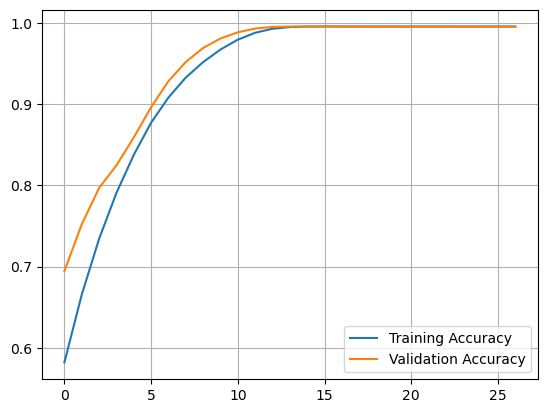

In [52]:
def plot_history_accuracy(history):
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

plot_history_accuracy(history=history)

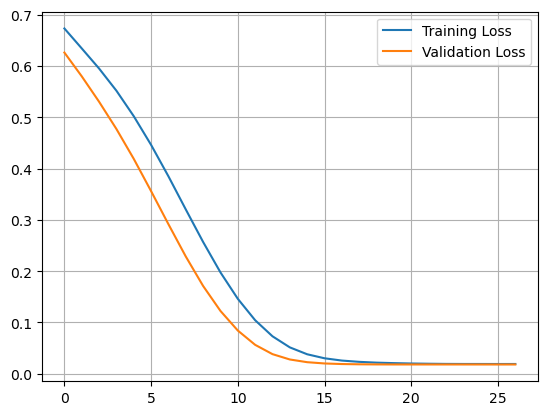

In [53]:
def plot_history_loss(history):
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.legend()
    plt.grid()
    plt.show()

plot_history_loss(history=history)

In [54]:
X_test_num = X_test.iloc[:, :126]  # Chọn 126 cột đầu tiên
X_test_text = X_test.iloc[:, -1]   # Chọn cột cuối cùng

# X_test_num = np.array(X_test_num, dtype=np.float32)
X_test_num = X_test_num.to_numpy(dtype=np.float32)

In [55]:
# Định nghĩa độ dài cố định cho X_train_text và X_val_text
max_len = max_length

# Chuyển đổi tất cả thành danh sách cùng kích thước
# X_test_text = np.array([seq[:max_len] + [0] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len] for seq in X_test_text], dtype=np.int32)
X_test_text = test_sequence_array

print("X_train_text shape:", X_test_text.shape)

X_train_text shape: (338915, 50)


In [56]:
predictions = model.predict([X_test_num, X_test_text],verbose = True)
predictions = (predictions >= 0.5).astype(int)

2025-05-02 01:28:17.173449: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 170813160 exceeds 10% of free system memory.


10592/10592 [==============================] - 57s 5ms/step


In [57]:
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(Y_test, predictions, target_names=['nAMP (Class 0)', 'AMP (Class 1)']))

                precision    recall  f1-score   support

nAMP (Class 0)       1.00      0.99      1.00    172500
 AMP (Class 1)       0.99      1.00      1.00    166415

      accuracy                           1.00    338915
     macro avg       1.00      1.00      1.00    338915
  weighted avg       1.00      1.00      1.00    338915



In [58]:
cm = confusion_matrix(Y_test, predictions)
cm = pd.DataFrame(cm, index=['nAMP', 'AMP'], columns=['nAMP', 'AMP'])

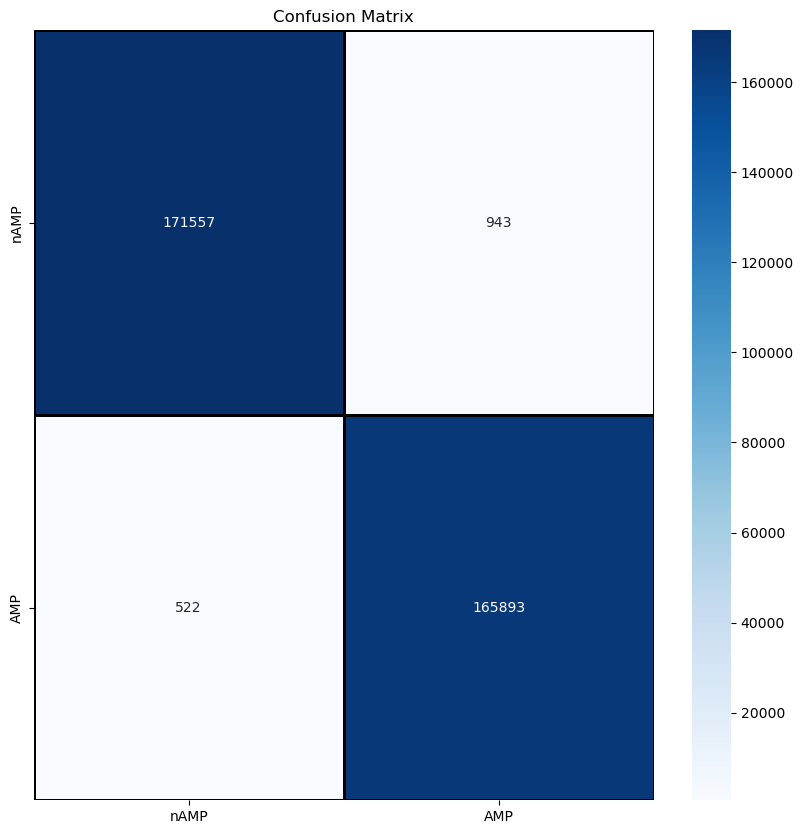

In [59]:
import seaborn as sns

plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='d', xticklabels=cm.columns, yticklabels=cm.index)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# model.load_weights('transfomer_peptide_weights.best.weights.h5')

In [60]:
X_test_num = X_test.iloc[:, :126]  # Chọn 126 cột đầu tiên
X_test_text = X_test.iloc[:, -1]   # Chọn cột cuối cùng

X_test_num = np.array(X_test_num, dtype=np.float32)

# Định nghĩa độ dài cố định cho X_train_text và X_val_text
max_len = 50  

# Chuyển đổi tất cả thành danh sách cùng kích thước
X_test_text = np.array([seq[:max_len] + [0] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len] for seq in X_test_text], dtype=np.int32)

In [61]:
num_features = X_train_num.shape[1]
text_features = X_train_text.shape[1]

def predict_proba_lime(X):
    X_num = X[:, 0:num_features]
    X_text = X[:, num_features:(num_features + text_features)] 
 
    # Dự đoán từ mô hình
    probs = model.predict([X_num, X_text])  
    
    print(f"Trước khi flatten {probs.shape}")
    probs = probs.flatten()  # Chuyển thành mảng một chiều
    print(f"Sau khi flatten {probs.shape}")

    # Xác suất cho class 0 và class 1
    probs_class_0 = 1 - probs  
    probs_class_1 = probs   
    print(f"probs_class_0 {probs_class_0.shape}")
    print(f"probs_class_1 {probs_class_1.shape}")

    result = np.hstack([probs_class_0[:, np.newaxis], probs_class_1[:, np.newaxis]])
    print(result)
    print(f"result {result.shape}")
    
    # Trả về mảng 2 chiều với xác suất của cả hai lớp
    return result# class 0, class 1

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

class_names = ['nAMP', 'AMP']

feature_names = data1.drop(columns=['ID', 'Label', 'Sequence']).columns.tolist()
text_feature_names = [f"num_feat_{i}" for i in range(X_train_text.shape[1])]
full_feature_names = feature_names + text_feature_names

X_train_combined = np.concatenate([X_train_num, X_train_text], axis=1)
    
explainer = LimeTabularExplainer(X_train_combined, feature_names =     
                                 full_feature_names,
                                 class_names = class_names, 
                                 mode = 'classification')

In [ ]:
sample_num = X_test_num[10]
sample_text = X_test_text[10]
sample = np.concatenate([sample_num, sample_text])

In [ ]:
exp = explainer.explain_instance(
    data_row=sample, 
    predict_fn=predict_proba_lime
)

exp.show_in_notebook(show_table=True)
exp.save_to_file('lime_explanation1.html')

In [ ]:
sample_num = X_test_num[11]
sample_text = X_test_text[11]
sample = np.concatenate([sample_num, sample_text])

In [ ]:
exp = explainer.explain_instance(
    data_row=sample, 
    predict_fn=predict_proba_lime
)

exp.show_in_notebook(show_table=True)
exp.save_to_file('lime_explanation2.html')

## Convert html thành png để post lên git

In [14]:
# !pip install selenium pillow

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from PIL import Image as PILImage
from IPython.display import Image, display
import time
import os

def save_lime_html_to_png(filename_base):
    """
    Convert a LIME explanation HTML file to PNG image and display it in notebook.
    
    :param filename_base: Tên file không đuôi (hoặc có đuôi .html) của file HTML LIME đã lưu
    """
    # ➕ Thêm .html nếu chưa có
    if not filename_base.endswith('.html'):
        filename_base += '.html'
    
    # 📍 Path đến file HTML
    html_file = os.path.abspath(filename_base)

    # ⚙️ Setup headless Chrome
    options = Options()
    options.add_argument('--headless')
    options.add_argument('--disable-gpu')
    options.add_argument('--window-size=1200,800')

    try:
        driver = webdriver.Chrome(options=options)

        # 🖼️ Load file HTML
        driver.get('file://' + html_file)
        time.sleep(2)  # đợi HTML render

        # 📸 Chụp màn hình và lưu
        output_file = filename_base.replace('.html', '.png')
        driver.save_screenshot(output_file)
        driver.quit()

        # ✅ Hiển thị ảnh trong notebook
        display(Image(filename=output_file))

    except Exception as e:
        print("❌ Lỗi khi chụp HTML:", e)


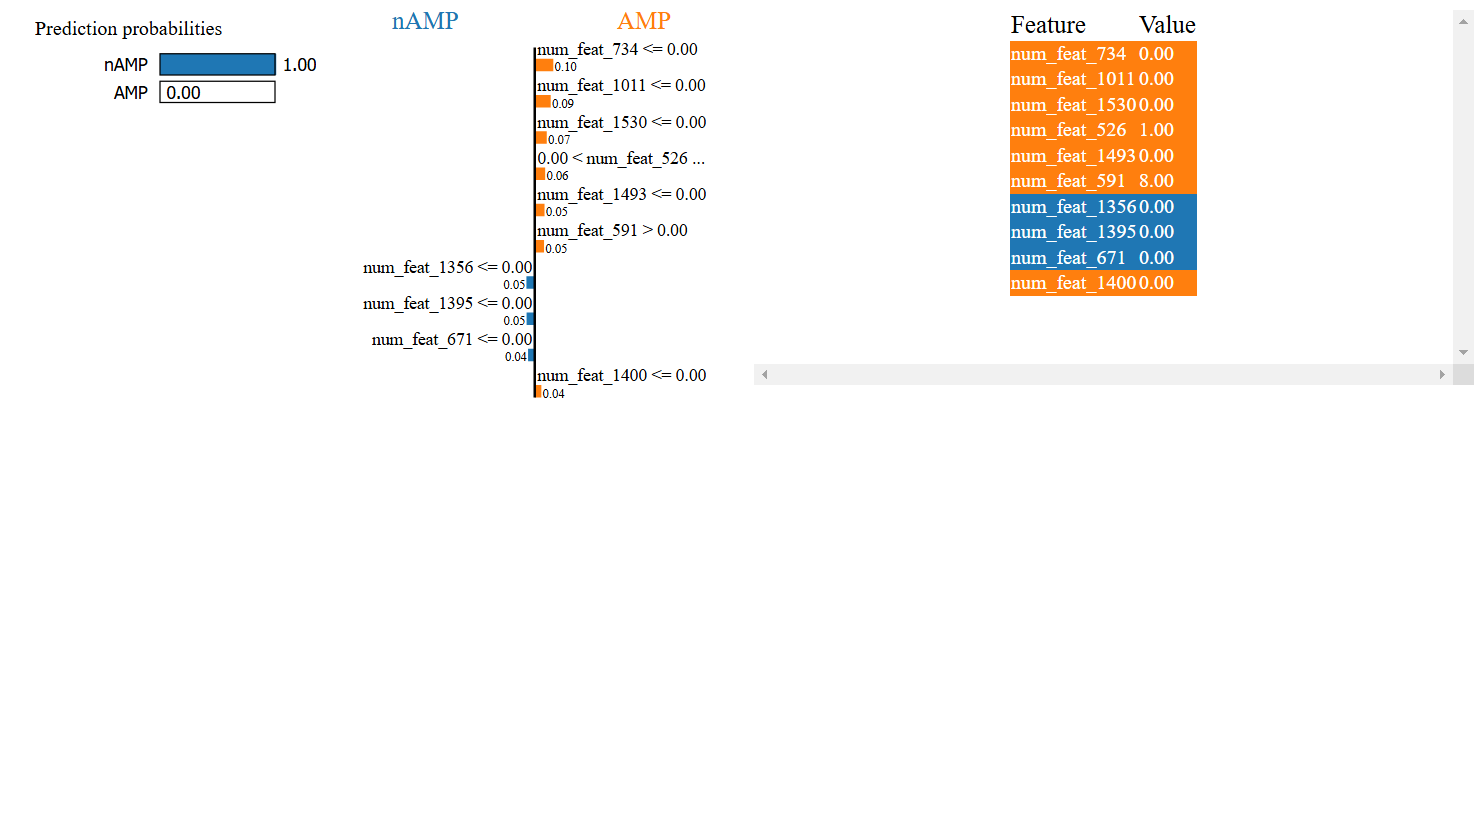

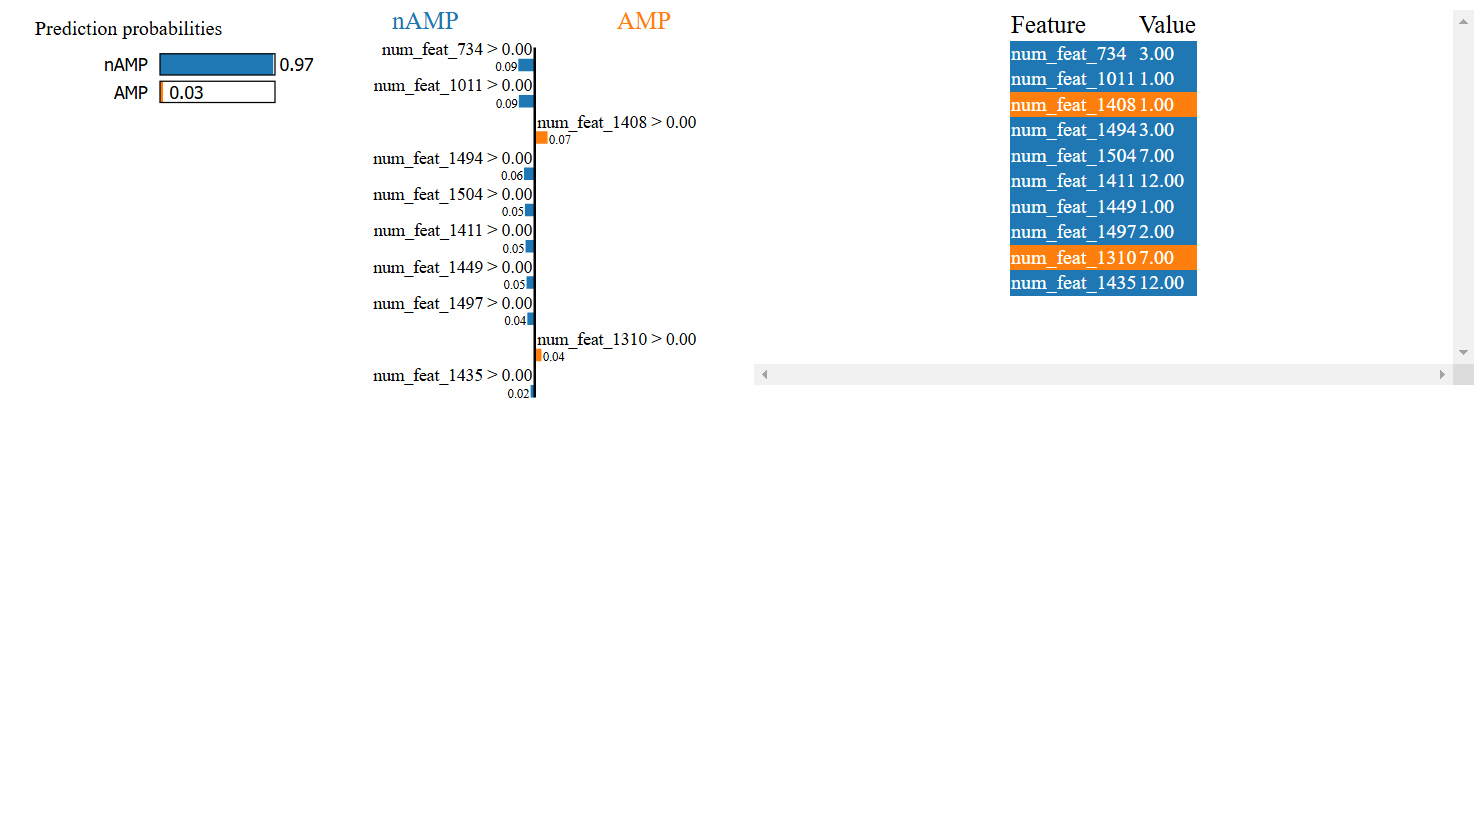

In [15]:
save_lime_html_to_png('lime_explanation1')
save_lime_html_to_png('lime_explanation2')